In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from preprocessing import preprocessing
from rdkit import Chem
from rdkit.Chem import AllChem, RDKFingerprint


#Ensemble learning and random forest

df = preprocessing("C:\\Users\Gilbert\Documents\BCB_Research\Kcat_Benchmark_ML_Models\kcat_transferase.csv")

In [9]:
d = df.copy()

d.head()

data = d

In [10]:
df.head()

,EC_number,Species,Compound,Compound_name,Amino_encoding,Kcat,unit
0,2.1.1.1,Homo sapiens,C1=CC(=CN=C1)C(=O)N,Nicotinamide,MESGFTSKDTYLSHFNPRDFLEKYYKFGSRHSAESQILKHLLKNLF...,0.0410,s^(-1)
1,2.1.1.1,Homo sapiens,C1=CC(=CN=C1)C(=O)N,Nicotinamide,MESGFTSKDTYLSHFNPRDYLEKYYKFGSRHSAESQILKHLLKNLF...,1.0200,s^(-1)
2,2.1.1.1,Homo sapiens,C1=CC(=CN=C1)C(=O)N,Nicotinamide,MESGFTSKDTYLSHFNPRDYLEKYYKFGSRHSAESQILKHLLKNLF...,0.0830,s^(-1)
3,2.1.1.10,Brassica oleracea,C(CS)C(C(=O)O)N,L-Homocysteine,MGLEKKSALLEDLIEKCGGCAVVDGGFATQLEIHGAAINDPLWSAV...,0.0375,s^(-1)
4,2.1.1.10,Escherichia coli,C(CS)C(C(=O)O)N,L-Homocysteine,MSQNNPLRALLDKQDILLLDGAMATELEARGCNLADSLWSAKVLVE...,0.3800,s^(-1)


In [11]:
#preprocessing
#lets encode the data using label encoder 
label_encoder = LabelEncoder()
data["EC_number"] = label_encoder.fit_transform(data["EC_number"])
data["Species"] = label_encoder.fit_transform(data["Species"])

amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
amino_to_index = {amino: i for i, amino in enumerate(amino_acids)}

# Convert amino acid sequences to one-hot encoding
def convert_to_one_hot(sequence):
    one_hot_sequence = np.zeros((len(sequence), len(amino_acids)))
    
    for i, amino in enumerate(sequence):
        if amino in amino_to_index:
            index = amino_to_index[amino]
            one_hot_sequence[i, index] = 1
            
    return one_hot_sequence.flatten()

# Apply the conversion to the DataFrame column
data["Amino"] = data["Amino_encoding"].apply(convert_to_one_hot).tolist()

# Drop the original 'Amino_encoding' column
data.drop(columns=["Amino_encoding"], inplace=True)

# convert compound name into numbers.
compound = data["Compound"]

data["smiles"] = [Chem.MolFromSmiles(smiles) for smiles in compound]

mol = data["smiles"]

data["Fingerprint_rdk"] = [RDKFingerprint(i) for i in mol]




[22:03:31] WARNING: not removing hydrogen atom without neighbors
[22:03:31] WARNING: not removing hydrogen atom without neighbors


In [12]:
data.head()

,EC_number,Species,Compound,Compound_name,Kcat,unit,Amino,smiles,Fingerprint_rdk
0,0,99,C1=CC(=CN=C1)C(=O)N,Nicotinamide,0.0410,s^(-1),"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",<rdkit.Chem.rdchem.Mol object at 0x0000020290D...,"[1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, ..."
1,0,99,C1=CC(=CN=C1)C(=O)N,Nicotinamide,1.0200,s^(-1),"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",<rdkit.Chem.rdchem.Mol object at 0x0000020290D...,"[1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, ..."
2,0,99,C1=CC(=CN=C1)C(=O)N,Nicotinamide,0.0830,s^(-1),"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",<rdkit.Chem.rdchem.Mol object at 0x0000020290D...,"[1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, ..."
3,1,39,C(CS)C(C(=O)O)N,L-Homocysteine,0.0375,s^(-1),"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",<rdkit.Chem.rdchem.Mol object at 0x0000020290D...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
4,1,81,C(CS)C(C(=O)O)N,L-Homocysteine,0.3800,s^(-1),"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",<rdkit.Chem.rdchem.Mol object at 0x00000202B02...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."


In [13]:
# train and split the data
# EC_number, Species, Amino, and fingerprint_rdk

from sklearn.model_selection import train_test_split


x_fingerprint = np.array(data['Fingerprint_rdk'].tolist())

x = x_fingerprint
# target variable
y = data["Kcat"]

# Ensure alignment of data
consistent_indices = np.arange(len(x))  # Assuming fingerprint and 'Kcat' data have the same length
x_train = x[consistent_indices]
y_train = y[consistent_indices]


x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=0)

In [14]:
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)

# Check data types
print("x_train data type:", type(x_train))
print("y_train data type:", type(y_train))



x_train shape: (3308, 2048)
y_train shape: (3308,)
x_train data type: <class 'numpy.ndarray'>
y_train data type: <class 'pandas.core.series.Series'>


In [22]:
# this initialization of the regression model
rf_regressor = RandomForestRegressor(n_estimators=150, max_depth=5, random_state=42)

rf_regressor.fit(x_train, y_train)

y_pred = rf_regressor.predict(x_test)


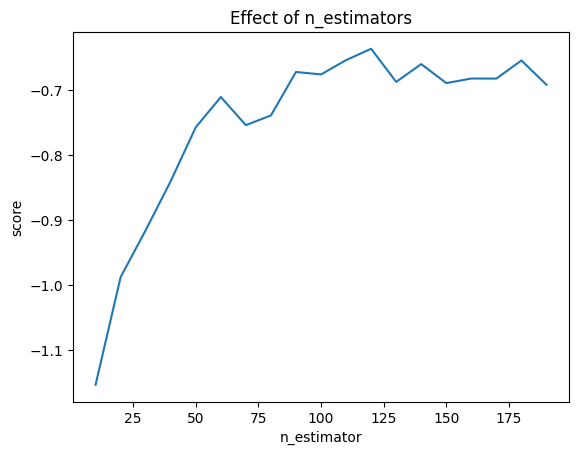

In [30]:
import matplotlib.pyplot as plt

estimators = np.arange(10, 200, 10)
scores = []
for n in estimators:
    rf_regressor.set_params(n_estimators=n)
    rf_regressor.fit(x_train, y_train)
    scores.append(rf_regressor.score(x_test, y_test))
plt.title("Effect of n_estimators")
plt.xlabel("n_estimator")
plt.ylabel("score")
plt.plot(estimators, scores)

In [20]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15],
    # Add more hyperparameters to search
}

rf_regressor = RandomForestRegressor(random_state=42)
random_search = RandomizedSearchCV(rf_regressor, param_distributions=param_grid, n_iter=10, cv=3, random_state=42)
random_search.fit(x_train, y_train)

best_rf_regressor = random_search.best_estimator_

c:\Users\Gilbert\anaconda3\envs\bcb\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [21]:
print(best_rf_regressor)

RandomForestRegressor(max_depth=5, n_estimators=150, random_state=42)


In [28]:
from sklearn.metrics import mean_absolute_error, mean_squared_error


print('MAE: ', mean_absolute_error(y_test, y_pred))
print('MSE: ', mean_squared_error(y_test, y_pred)) 


MAE:  192.76026811089503
MSE:  281202.75483266654


In [ ]:
from sklearn.model_selection import GridSearchCV

# helps finding the optimal hyperparameters
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15],
    # Add more hyperparameters and values
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid=param_grid, cv=3)
grid_search.fit(x_train, y_train)

best_rf_regressor = grid_search.best_estimator_